In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import random
import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import numpy as np

import sys; sys.path.append('../')
from rh_prior import horseshoe_prior
from misc import h5file
import yaml
import statsmodels.api as sm

In [2]:
noise_lv = 30
fp1 = "./IPI_output_files/PMS_data.h5"
fp2 = "./IPI_output_files/encoded_pde_names.yaml"
X_pre, best_subsets, un, y_pre = h5file(file_path=fp1, mode='r', return_dict=False)

with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]
encoded_pde_names

['X_pre', 'best_subsets', 'un', 'y_pre']


['u*u_1',
 'u_111+u*u_1',
 'u_111+u*u_1+u*u_111',
 'u_111+u*u_1+u*u*u_1+u*u_111',
 'u_1+u_111+u*u_1+u*u_111+u*u*u_111',
 'u+u_1+u_111+u*u_1+u*u_111+u*u*u_111',
 'u+u_1+u_111+u*u_1+u*u_11+u*u_111+u*u*u_111',
 'u+u_1+u_111+u*u_1+u*u*u_1+u*u_11+u*u_111+u*u*u_111',
 'u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u_111+u*u*u_111',
 'u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111',
 'u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111',
 'u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111',
 'u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111+u*u*u_1111',
 'u+u*u+u_1+u_11+u_111+u_1111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111+u*u*u_1111']

In [3]:
bic_sel_complexity = 7
max_complexity = len(best_subsets)//2
hie = [np.where(best_subsets[i]>0)[0].tolist() for i in range(best_subsets.shape[-1])][:max_complexity]
hie

[[6],
 [4, 6],
 [4, 6, 10],
 [4, 6, 7, 10],
 [2, 4, 6, 10, 11],
 [0, 2, 4, 6, 10, 11],
 [0, 2, 4, 6, 8, 10, 11]]

In [4]:
# Define the Bayesian linear regression model
X_sup = X_pre[:, hie[-1]]
y_sup = y_pre.ravel()
support_sizes = X_sup.shape[-1]
init_beta = np.linalg.lstsq(X_sup, y_sup, rcond=-1)[0]
init_sigma = np.mean((X_sup@init_beta-y_sup)**2)
print(init_beta, init_sigma)
n_samples = 4000

slab_df = 4
slab_scale = 2
tau0 = 1e-3

np.random.seed(0)
with pm.Model() as model:
    tau = pm.HalfStudentT('tau', nu=1, sigma=tau0)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=support_sizes)
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    z  = pm.Normal('z', mu=0, sigma=1, shape=support_sizes)
    pn = pm.Deterministic('pn', z*tau*lt)
    coeffs = pm.Deterministic('coeffs', z*tau*lt)
    
    sigma = pm.Exponential('sigma', lam=init_sigma)
    mu = pm.math.dot(X_sup, coeffs)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sup)

    # Perform MCMC sampling
#     trace = pm.sample(n_samples, tune=n_samples//2, chains=4, cores=4, 
#                       # nuts={'target_accept':0.99}, 
#                       nuts={'target_accept':0.99, 'max_treedepth':12}, 
#                       return_inferencedata=True)
    # trace = pmjax.sample_numpyro_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=True)
    trace = pmjax.sample_blackjax_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=True)
    pm.compute_log_likelihood(trace)
    idata = pm.sample_smc(draws=n_samples, progressbar=False, cores=4)

[-0.00272839 -0.02550555 -0.90364348 -0.96685633 -0.00405048 -0.19253602
  0.07679068] 0.004769484870843118
Compiling...
Compilation time =  0:00:03.731153
Sampling...
Sampling time =  0:00:06.351726
Transforming variables...
Transformation time =  0:08:42.010917


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
trace.to_netcdf("kdv_rh.trace", overwrite_existing=True)
idata.to_json("kdv_rh_idata.json")

'kdv_rh_idata.json'

In [40]:
# trace = trace.from_netcdf("burgers_rh.trace")
post = idata.posterior

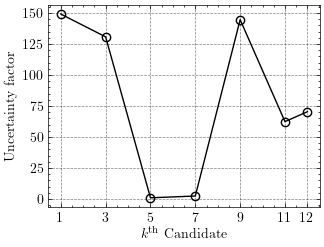

In [41]:
data = np.array(post.coeffs).reshape(-1, bic_sel_complexity)
uncert = np.abs(data.std(axis=0)/data.mean(axis=0))
uncert = uncert/min(uncert)
index = np.argsort(uncert)
data = data[:, index]

with plt.style.context(['science', 'grid']):
    plt.plot([i+1 for i in sorted(np.array(hie[-1])[index])], uncert, 'o-', c='black', markerfacecolor='none')
    plt.xticks([i+1 for i in sorted(np.array(hie[-1])[index])])
#     plt.title("Regularized horseshoe prior")
    plt.xlabel("$k^{\\textrm{th}}$ Candidate")
    plt.ylabel("Uncertainty factor")
    plt.savefig("../Figures/KdV/rh_uncert.pdf")
    plt.show()

In [42]:
[encoded_feature_names[i] for i in np.array(hie[-1])[index]], index # Set columns accordingly

(['u_111', 'u*u_1', 'u*u_111', 'u*u*u_111', 'u_1', 'u*u_11', 'u'],
 array([2, 3, 5, 6, 1, 4, 0]))

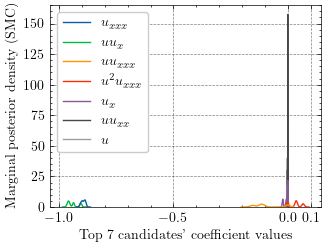

In [43]:
with plt.style.context(['science', 'grid']):
    sns.kdeplot(pd.DataFrame(data, columns=["$u_{xxx}$", "$uu_{x}$", "$uu_{xxx}$", "$u^{2}u_{xxx}$", "$u_{x}$", "$uu_{xx}$", "$u$"]))
    plt.ylabel("Marginal posterior density (SMC)")
    plt.xticks([-1., -0.5, 0, 0.1])
    plt.xlabel("Top 7 candidates' coefficient values")
    plt.savefig("../Figures/KdV/rh_posterior.pdf")
    plt.show()